# Deep Learning Analysis of X-Ray Images for Pneumonia Detection

![image](banner.png)

## Authors :
- Ida Chepng'eno
- Brenda Ngigi
- Edwin Mwai
- Neville Ngenzi
- Collins Chumba
- Charles Ndung'u
- Beatrice Adhiambo
- Mike Kiptoch

## 1. Business Understanding

### a) Introduction

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid, causing cough, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia. Pneumonia can range in seriousness from mild to life-threatening and it is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems; [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204#:~:text=Pneumonia%20is%20an%20infection%20that,and%20fungi%2C%20can%20cause%20pneumonia.).


The rapid advancement of Artificial Intelligence (AI) has brought significant benefits across various industries, including healthcare. Traditionally, diagnosing pneumonia requires time-consuming physical examinations and lab tests, often necessitating multiple doctor visits.
To address this issue, we aim to develop a deep learning model capable of accurately detecting pneumonia from chest x-ray images. Such a tool holds immense value for healthcare professionals and patients, enabling quicker and more precise diagnoses. Radiologists and other specialists can leverage this technology to enhance their diagnostic accuracy, ultimately leading to better patient care and treatment outcomes.

### b) Problem Statement

**What is the prevailing circumstance?**

Early detection and treatment of pneumonia are essential for avoiding complications and enhancing clinical results. Detecting pneumonia is not only a medical necessity but also a humanitarian imperative and a technological frontier. Chest X-rays are a frequently used imaging modality for diagnosing pneumonia. 


**What problem is being addressed?**

According to the [World Health Organization](https://www.who.int/news-room/fact-sheets/detail/pneumonia), Pneumonia accounts for 14% of all deaths of children under 5 years old, killing 740 180 children in 2019. Chest X-ray imaging serves as a prevalent diagnostic tool for pneumonia, offering insights such as increased lung opacity. Nevertheless, interpreting chest X-rays poses challenges due to the subtle nature of pneumonia symptoms and their potential overlap with other respiratory conditions. Analyzing radiological images, including chest X-rays and CT scans, demands specialized expertise and can consume significant time in the diagnostic process.


**How the project aims to solve the problem?**

To address this issue, this project aims to develop a deep learning model capable of accurately detecting pneumonia from chest x-ray images. Such a tool holds immense value for healthcare professionals and patients, enabling quicker and more precise diagnoses. Radiologists and other specialists can leverage this technology to enhance their diagnostic accuracy, ultimately leading to better patient care and treatment outcomes.


### c) Objectives

#### Main Objectives

- Develop a deep learning model to accurately identify pneumonia from chest x-ray images.


#### Business Objectives


- Provide pediatricians with a fast and precise tool for pneumonia diagnosis in children, potentially reducing unnecessary hospital visits and improving outcomes.
- Enhance access to pneumonia diagnosis in low-resource settings without immediate access to trained medical professionals.
- Potentially lower healthcare expenses by enabling early diagnosis and treatment of pneumonia in pediatric cases.
- Contribute to building a comprehensive dataset for pneumonia diagnosis, facilitating further research and model advancement.
- Develop a user-friendly model for seamless integration into existing hospital or clinic workflows, ensuring efficient and streamlined diagnosis processes.

### d) Notebook Structure

i) Business Understanding<br>
ii) Data Understanding<br>
iii) Exploratory Data Analysis<br>
iv) Data Preprocessing<br>
v) Modeling<br>
vi) Evaluation<br>
vii) Conclusion<br>
viii) Recommendation<br>
ix) Next Steps<br>

### e) Stakeholders

Key stakeholders interested in leveraging deep learning for medical imaging include: healthcare professionals, patients, hospitals, medical device manufacturers, and insurance companies. For instance, hospitals can optimize resource allocation and improve treatment efficacy, while medical device manufacturers can enhance product development for more accurate diagnoses. Additionally, researchers and government agencies stand to benefit from these advancements, using the models to deepen disease understanding and ensure regulatory compliance.


### f) Metric of Success

The performance of the model is evaluated based on:
* Accuracy - achieving an accuracy of over 85%
* Recall - achieving a recall of over 65%
* Loss Function - minimize loss function to ensure the model is not overfitting

## 2. Data Understanding

The dataset used in this project was obtained from [Mendley Data](https://data.mendeley.com/datasets/rscbjbr9sj/3). It comprises of 5,863 JPEG images categorized into two classes: "Pneumonia" and "Normal." It is organized into three main folders: "train," "test," and "val," each containing subfolders corresponding to the image categories.

The chest X-ray images, captured in the anterior-posterior view, were obtained from pediatric patients aged one to five years old at Guangzhou Women and Children’s Medical Center, Guangzhou. These images were part of routine clinical care procedures.

Before inclusion in the dataset, all chest radiographs underwent a quality control process to remove any low-quality or unreadable scans. Subsequently, the diagnoses assigned to the images were graded by two expert physicians. To mitigate potential grading errors, a third expert also evaluated the images in the evaluation set.

Overall, this dataset provides a curated collection of chest X-ray images, ensuring quality and accuracy through rigorous quality control measures and expert evaluation, making it suitable for training AI systems for pneumonia diagnosis.

### Importing Libraries

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from keras import layers, models, regularizers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from keras.preprocessing import image
from PIL import Image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")


### Loading our datasets 

- Images are loaded and preprocessed from designated directories, with pixel values rescaled to a range of 0 to 1, and dimensions specified by the target_size parameter, while class_mode is set to 'binary' for binary classification.

In [2]:
# Set the paths to train, test, and validation folders
train_folder = 'chest_xray/train'
test_folder = 'chest_xray/test'
val_folder = 'chest_xray/val'

# Downsampling the images to 128X128 pixels
downsampled_size = (128, 128)

# Define batch sizes
train_batch_size = 5216
test_batch_size = 624
val_batch_size = 16

# Rescale pixel values between 0 and 1
datagen = ImageDataGenerator(rescale=1./255)  

def load_data(data_dir, batch_size, datagen, downsampled_size, is_train_data):
    try:
        generator = datagen.flow_from_directory(
            data_dir,
            target_size=downsampled_size,
            batch_size=batch_size,
            class_mode='binary',
            shuffle=is_train_data
        )
    except Exception as e:
        raise Exception(f"Error loading data from {data_dir}: {e}") from e
    return generator

# Load the train data
train_generator = load_data(train_folder, train_batch_size, datagen, downsampled_size, True)

# Load the test data
test_generator = load_data(test_folder, test_batch_size, datagen, downsampled_size, False)

# Load the validation data
val_generator = load_data(val_folder, val_batch_size, datagen, downsampled_size, False)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


- The dataset comprises three folders: 
  - "train" with 5,216 images, 
  - "test" with 624 images,
  - "validation" with 16 images.

- Each of the folders contains two classes: normal chest X-rays and chest X-rays with pneumonia.

## 3. Exploratory Data Analysis


This step involves examining and understanding the dataset before applying machine learning algorithms. 

It will guide in processes like: data preprocessing, model selection, and performance evaluation strategies.
 
The EDA performed on the dataset includes visualizing samples of normal and pneumonia chest X-ray images, and plotting the class distributions for the training, test, and validation sets.

#### 3.1) Displaying sample images from the dataset

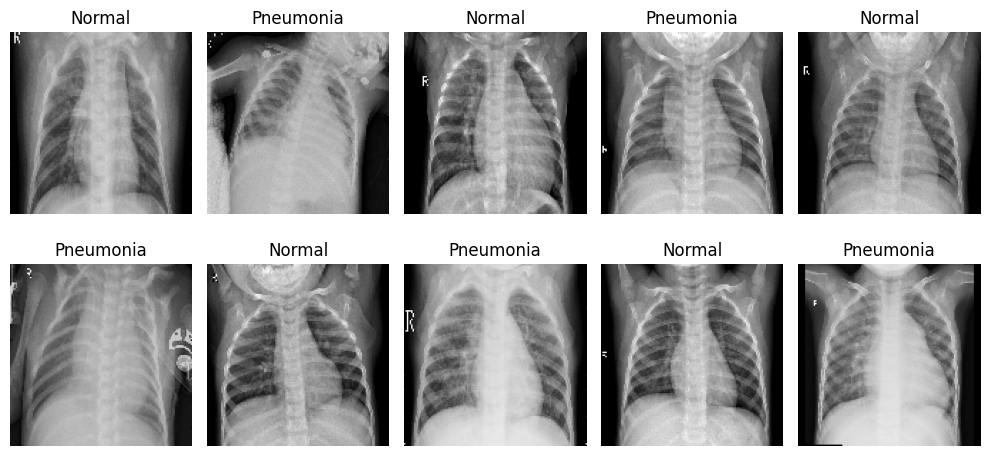

In [3]:
# Define the number of images to display
num_images = 10

# Create a 2x5 subplot figure with adjusted aspect ratio
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

# Get a batch of 'Normal' images
normal_images, _ = next(train_generator)

# Get a batch of 'Pneumonia' images
pneumonia_images, _ = next(train_generator)

# Loop over the first few images
for i in range(min(num_images, len(normal_images), len(pneumonia_images))):
    # Display the image
    if i % 2 == 0:
        axes[i].imshow(normal_images[i], cmap='gray')
        axes[i].set_title('Normal')
    else:
        axes[i].imshow(pneumonia_images[i], cmap='gray')
        axes[i].set_title('Pneumonia')
    # Remove the axis
    axes[i].axis('off')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


The samples above show suggest that distinguishing between chest X-ray images without pneumonia and those with pneumonia  is challenging due to their visual resemblance.

#### 3.2) Mapping and class labels associated with the training data

In [4]:
# Retrieve the dictionary of class indices from the train_generator
dict_class = train_generator.class_indices
print(f'Dictionary: {dict_class}')

# Get the list of class labels
class_names = list(dict_class.keys())
print(f'Class labels: {class_names}')


Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


- The class labels were mapped to their corresponding numerical indices. 

- 'NORMAL' corresponds to class index 0, while 'PNEUMONIA' corresponds to class index 1.

- This is vital for training and evaluating deep learning models.

#### 3.3) Displaying sample images from the dataset, with the corresponding labels serving as titles for each subplot.

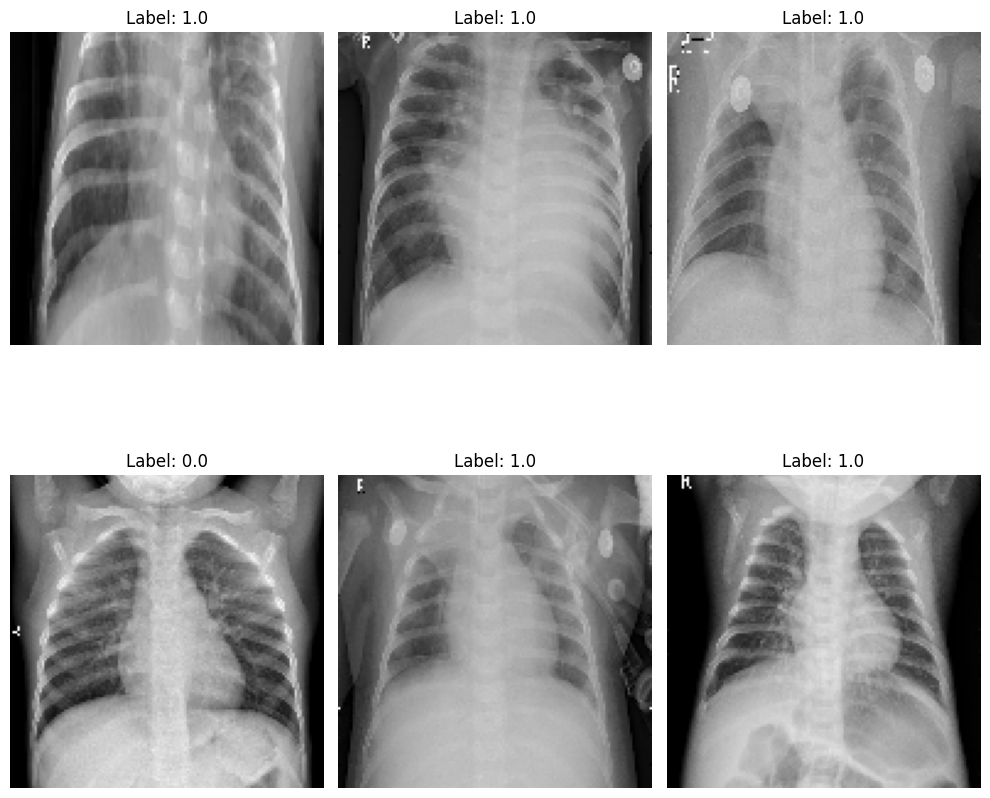

In [5]:
# Get a batch of images from the train generator
batch = next(train_generator)

# Extract the images and labels from the batch
images, labels = batch

# Display the first few images with their corresponding labels
num_images = 6

fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for i in range(num_images):
    axes[i//3, i%3].imshow(images[i], cmap='RdBu')
    axes[i//3, i%3].set_title('Label: {}'.format(labels[i]))
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()

The labels changed to 0 for a normal chest X-Ray and 1 for a chest X-Ray with pneumonia.

#### 3.4) Visualizing the distribution of classes in each category of data.

##### A function to visualize distribution of classes in each category of data.

In [48]:

def plot_class_counts(labels, title, bar_colors):
    """
    Visualizes the class distributions.
    
    Args:
        labels (array-like): The class labels.
        title (str): The title of the plot.
        bar_colors (list): The list of colors for the bars.
    """
    # Get the counts for each class
    class_labels, counts = np.unique(labels, return_counts=True)
    
    # Calculate the percentage of value counts
    total_count = np.sum(counts)
    percentages = counts / total_count * 100
    
    # Plot the results
    plt.figure(figsize=(5, 5))
    plt.title(title, fontsize=12)
    plt.xlabel("Classes")
    plt.ylabel("Count")
    
    # Replace "1" with "Normal" in class_labels list
    class_labels = ['Pneumonia', 'Normal']
    
    # Add percentages as text on top of each bar
    for i in range(len(class_labels)):
        plt.text(i, counts[i], f"{percentages[i]:.2f}%", ha='center', va='bottom')
    
    # Plot the bar plot with specified colors
    sns.barplot(x=class_labels, y=counts, palette=bar_colors)
    
    plt.show()




##### 3.4.1) Visualizing the distribution of classes in the Train data

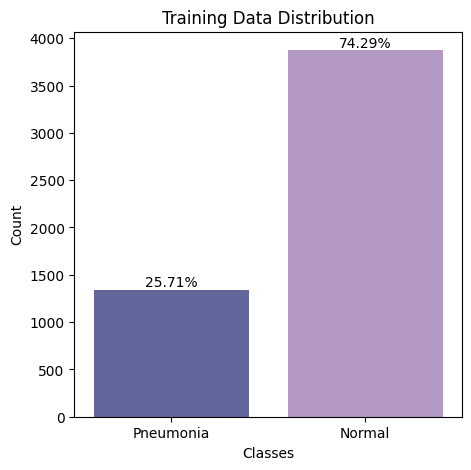

In [49]:
# Define the colors for the bars
bar_colors = ["#5a5ea3", "#b491ca"]

# Training data distribution
labels = train_generator.classes
plot_class_counts(labels, 'Training Data Distribution', bar_colors)


- Approximately 75% of the training data consists of normal chest X-rays while about 25% contains X-rays with pneumonia.

##### 3.4.2) Visualizing the distribution of classes in the Test Data 

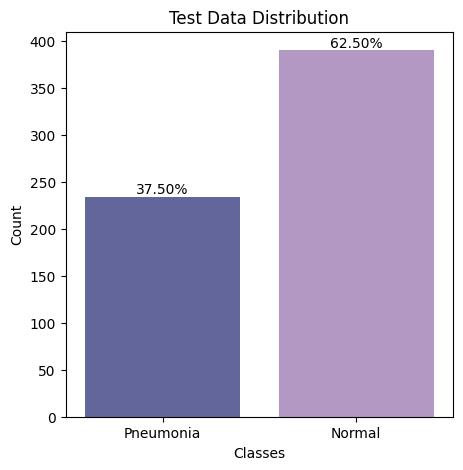

In [50]:
# Define the colors for the bars
bar_colors = ["#5a5ea3", "#b491ca"]

# Test data distribution
test_labels = test_generator.classes
plot_class_counts(test_labels, 'Test Data Distribution', bar_colors)


- Approximately 63% of the Test Data consists of normal chest X-rays while almost 38% contains X-rays with pneumonia.

##### 3.4.3) Visualizing the distribution of classes in the Validation Data 

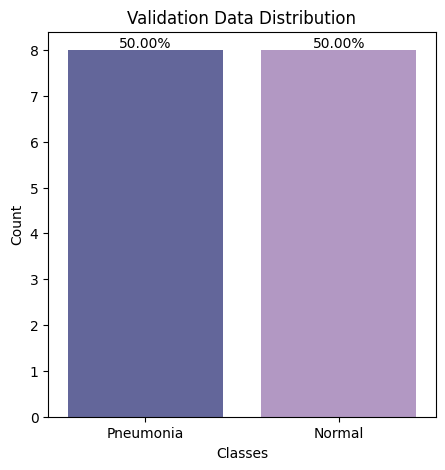

In [51]:
# Define the colors for the bars
bar_colors = ["#5a5ea3", "#b491ca"]

# Validation data distribution
val_labels = val_generator.classes
plot_class_counts(val_labels, 'Validation Data Distribution', bar_colors)


- The distribution between the two classes (Pneumonia and Normal) is approximately even.

#### 3.5) Analyzing the distribution of image sizes (width and height)

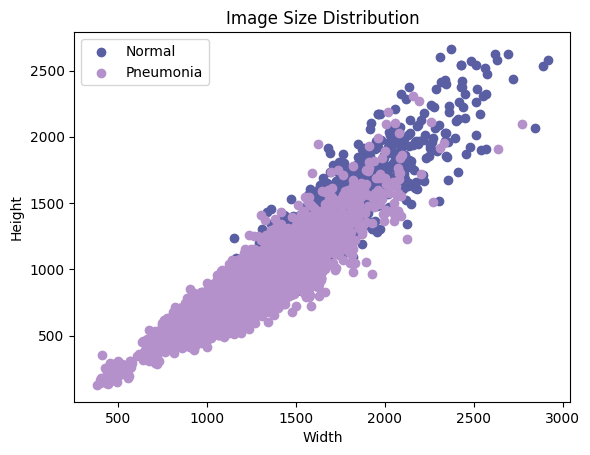

In [55]:

normal_image_sizes = []
pneumonia_image_sizes = []

for image_path in train_generator.filepaths:
    img = Image.open(image_path)
    width, height = img.size
    if "NORMAL" in image_path:
        normal_image_sizes.append((width, height))
    else:
        pneumonia_image_sizes.append((width, height))

normal_image_sizes = np.array(normal_image_sizes)
pneumonia_image_sizes = np.array(pneumonia_image_sizes)

plt.scatter(normal_image_sizes[:, 0], normal_image_sizes[:, 1], label='Normal', color='#5a5ea3')
plt.scatter(pneumonia_image_sizes[:, 0], pneumonia_image_sizes[:, 1], label='Pneumonia', color='#b491ca')

plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Size Distribution')
plt.legend()
plt.show()


The visualization above indicates that X-ray images of normal lungs are slightly larger in dimensions as compared to those of pneumonia-infected lungs.

## 4. Data Preprocessing

#### 4.1) Extracting the images and labels

The images and labels were extracted from the train, test, and validation generators, and returned as arrays. 
The train_images array holds the image data, while the train_labels array contains corresponding labels.


In [11]:
# obtain images and labels from the test generator
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

#### 4.2) Checking the information of the datasets

Information regarding the shape and size of both the image and label datasets was explored and displayed. Printing these values provides an overview of the dataset's sample count and the dimensions of the image and label arrays.

In [12]:
# Explore the shape of the images and labels
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

train_labels =np.array(train_labels)
test_labels =np.array(test_labels)
val_labels = np.array(val_labels)


print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216,)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624,)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16,)


- There are 5216 training samples, 624 testing samples, and 16 validation samples.
- Each image in the datasets is represented as a 128x128x3 array (128x128 pixels with 3 color channels).
- The labels for each dataset are represented as one-dimensional arrays with lengths corresponding to the number of samples in each dataset.

#### 4.3) Reshaping the images.

The images were converted from their original 3-dimensional shape (height x width x channels) into a flattened format. This flattened representation allows the images to be easily processed and fed into machine learning models.

In [13]:
# Reshaping the images
# number of images per data, 128X128X3
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 49152)
(624, 49152)
(16, 49152)


The image data arrays train_images, test_images, and val_images are reshaped into a 2D format where each row represents an image and each column represents a pixel value.

Importantance:

1. **Standardization of Input Format**: Reshaping ensures that the input data conforms to the expected shape, making it compatible with the model's architecture.

2. **Vectorization**: Reshaping the images into a 2D format  converts each image from a 2D or 3D array into a 1D array. Vectorization allows for easier processing and manipulation of the data.

3. **Consistency**: It ensures that all datasets have the same shape, making it easier to train and evaluate models consistently.



## 5. Modeling


### 5.1) Baseline model : A Densely Connected Neural Network


Initially, a baseline fully connected network is constructed utilizing the Keras Sequential API. This network consists of two hidden layers followed by an output layer. The first two layers incorporate ReLU activation functions, which introduce non-linearity to the network, enabling it to learn complex patterns in the data. Meanwhile, the final layer employs a sigmoid activation function, which outputs probabilities between 0 and 1, making it suitable for binary classification tasks. 

In [14]:
# Build a baseline fully connected network

#initialize a sequential model
model_1 = models.Sequential()

#2 layers with relu activation
model_1.add(layers.Dense(64, activation='relu', input_shape=(49152,))) 
model_1.add(layers.Dense(32, activation='relu'))

#one layer with sigmoid activation
model_1.add(layers.Dense(1, activation='sigmoid'))

In [15]:
#compile the model
model_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Inspecting the model summary.

In [16]:
model_1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │     3,145,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,147,905 (12.01 MB)

 Trainable params: 3,147,905 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

*  This baseline model has 3,147,905 trainable parameters!

In [17]:
#train the model
results_1 = model_1.fit(train_img,
                    train_labels,
                    epochs=10,
                    batch_size=100,

                    validation_data=(val_img, val_labels))

Epoch 1/10


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6978 - loss: 0.6159 - val_accuracy: 0.5000 - val_loss: 0.8200
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7453 - loss: 0.4650 - val_accuracy: 0.5000 - val_loss: 1.0421
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7984 - loss: 0.4225 - val_accuracy: 0.5000 - val_loss: 1.0789
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8009 - loss: 0.4152 - val_accuracy: 0.5000 - val_loss: 1.7165
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8354 - loss: 0.3909 - val_accuracy: 0.8125 - val_loss: 0.4631
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8758 - loss: 0.3108 - val_accuracy: 0.8125 - val_loss: 0.5240
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8892 - loss: 0.2878 - val_accuracy: 0.8125 - val_loss: 0.4395
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9030 - loss: 0.2702 - val_accuracy: 0.6875 - val_loss: 0.

Inspecting the model's performance and detecting overfitting or other issues by plotting:

- The loss and val_loss over the training epochs
- The acc and val_acc over the training epochs


In [18]:
def model_metrics(model, images, labels):
    """Function that returns loss and accuracy of a model"""
    loss, accuracy = model.evaluate(images, labels)
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    return loss, accuracy

In [19]:
Training_Results = model_metrics(model_1, train_img, train_labels)
Training_Results

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9077 - loss: 0.2439
Loss: 0.2448
Accuracy: 0.9074


(0.2447787970304489, 0.9074003100395203)

In [20]:
Validation_Results = model_metrics(model_1, val_img, val_labels)
Validation_Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8750 - loss: 0.3399
Loss: 0.3399
Accuracy: 0.8750


(0.3398865759372711, 0.875)

- This model consists of two hidden layers with ReLU activation and an output layer with sigmoid activation.
The final training accuracy of 93.94% and validation accuracy of 87.50% suggest that the model has learned to classify the chest X-ray images reasonably well.

The baseline model (model_1) shows promising results, but the overfitting issue needs to be addressed through techniques such as regularization, dropout, or architectural modifications to improve the model's generalization capabilities and achieve better validation/test performance.

### 5.2) Model 2: Convolutional Neural Network


The second model comprises a sequential architecture consisting of two convolutional layers, each followed by max pooling layers. These convolutional layers are responsible for extracting features from the input images, while the subsequent max pooling layers reduce the spatial dimensions of the feature maps. Finally, the model concludes with a dense layer, which performs the classification task.

In [21]:
# Initialize a sequential model 
model_2 = models.Sequential()

# Add 2 convolutional layers with pooling
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into the next layer
model_2.add(layers.Flatten())

# Add a dense layer for classification
model_2.add(layers.Dense(1, activation='sigmoid'))


In [22]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])

# Print a summary of the model architecture
model_2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        28,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,057 (191.63 KB)

 Trainable params: 49,057 (191.63 KB)

 Non-trainable params: 0 (0.00 B)

 Total trainable parameters are 49,057

In [23]:
results_2 = model_2.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=100,
                    validation_data=(val_images, val_labels))

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7136 - loss: 0.5701 - val_accuracy: 0.7500 - val_loss: 0.6169
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7743 - loss: 0.4784 - val_accuracy: 0.5000 - val_loss: 0.7802
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7746 - loss: 0.4578 - val_accuracy: 0.7500 - val_loss: 0.4924
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8517 - loss: 0.3532 - val_accuracy: 0.6250 - val_loss: 1.1295
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8843 - loss: 0.2821 - val_accuracy: 0.6250 - val_loss: 0.7761
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9060 - loss: 0.2375 - val_accuracy: 0.8750 - val_loss: 0.3672
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9200 - loss: 0.2139 - val_accuracy: 0.8125 - val_loss: 0.3435
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9128 - loss: 0.2173 - val_accuracy: 0.6250 - val_loss:

In [24]:
#model evaluation
Training_Results = model_metrics(model_2, train_images, train_labels)
Training_Results


163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.9489 - loss: 0.1470
Loss: 0.1486
Accuracy: 0.9457


(0.14862090349197388, 0.9457438588142395)

In [25]:
#model evaluation
Validation_Results = model_metrics(model_2, val_images, val_labels)
Validation_Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8125 - loss: 0.3646


Loss: 0.3646
Accuracy: 0.8125


(0.3645820617675781, 0.8125)

- The convolutional neural network model (model_2) achieves a reasonable training accuracy of 80.41%, but its performance on the validation set is significantly worse, with a validation accuracy of only 56.25%.
- To improve the model's performance, further techniques such as regularization, dropout, or architectural modifications may be necessary to address the overfitting issue and enhance the model's ability to generalize to new, unseen data.

### 5.3) Model 3 - CNN with Architecture modifications
#### Adding More Layers


The architecture of the model was modified by adding more convolutional layers, increasing the number of filters in each layer and  introducing two additional dense layers after the flattening layer.

In [26]:


model_3 = Sequential()
model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(1, activation='sigmoid'))

In [27]:
# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [28]:
# Train the model using the train set of images
results_3 = model_3.fit(train_images,
                    train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 436ms/step - accuracy: 0.7827 - loss: 0.4992 - val_accuracy: 0.7500 - val_loss: 0.6256
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 432ms/step - accuracy: 0.9506 - loss: 0.1395 - val_accuracy: 0.7500 - val_loss: 0.3813
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 494ms/step - accuracy: 0.9640 - loss: 0.1124 - val_accuracy: 0.6875 - val_loss: 0.4087
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 483ms/step - accuracy: 0.9671 - loss: 0.0950 - val_accuracy: 0.7500 - val_loss: 0.4940
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 491ms/step - accuracy: 0.9733 - loss: 0.0816 - val_accuracy: 0.7500 - val_loss: 0.4132
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 545ms/step - accuracy: 0.9683 - loss: 0.0807 - val_accuracy: 0.7500 - val_loss: 0.5961
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 390ms/step - accuracy: 0.9806 - loss: 0.0646 - val_accuracy: 0.9375 - val_loss: 0.2767
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 397ms/step - accuracy: 0.9829 - loss: 0

In [29]:
#model  perfomance evaluation
Training_Results = model_metrics(model_3, train_images, train_labels)
Training_Results

163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.9939 - loss: 0.0166
Loss: 0.0185
Accuracy: 0.9927


(0.01845330372452736, 0.9927147030830383)

In [30]:
#model  perfomance evaluation
Validation_Results = model_metrics(model_3, val_images, val_labels)
Validation_Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 0.0713
Loss: 0.0713
Accuracy: 1.0000


(0.0713377594947815, 1.0)

- This model further enhances the architecture by adding more convolutional and dense layers.
- The model achieves a training accuracy of 98.66% and a validation accuracy of 75.00%.

## 6) Model Evaluation


The performance of the two tuned models (Model 2 and Model 3) is compared using the following metrics:

* Test Loss
* Test Accuracy
* Test Precision



In [31]:

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='true_positives', initializer='zeros')
        self.fp = self.add_weight(name='false_positives', initializer='zeros')
        self.fn = self.add_weight(name='false_negatives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        true_positives = tf.math.count_nonzero(y_pred * y_true, axis=-1)
        false_positives = tf.math.count_nonzero(y_pred * (1 - y_true), axis=-1)
        false_negatives = tf.math.count_nonzero((1 - y_pred) * y_true, axis=-1)

        self.tp.assign_add(tf.reduce_sum(true_positives))
        self.fp.assign_add(tf.reduce_sum(false_positives))
        self.fn.assign_add(tf.reduce_sum(false_negatives))

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-12)
        recall = self.tp / (self.tp + self.fn + 1e-12)
        f1 = 2 * precision * recall / (precision + recall + 1e-12)
        return f1

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

In [32]:
# Compare the two tuned models
test_loss_1, test_acc_1 = model_2.evaluate(test_generator)
test_loss_2, test_acc_2 = model_3.evaluate(test_generator)

# Get predictions for model 2 and calculate precision
model_2_preds = model_2.predict(test_generator)
model_2_preds = np.round(model_2_preds)
precision_1 = precision_score(test_generator.labels, model_2_preds)

# Get predictions for model 3 and calculate precision
model_3_preds = model_3.predict(test_generator)
model_3_preds = np.round(model_3_preds)
precision_2 = precision_score(test_generator.labels, model_3_preds)

# Create the results dictionary
results = {
    'Model': ['Model 1', 'Model 2'],
    'Test Loss': [test_loss_1, test_loss_2],
    'Test Accuracy': [test_acc_1, test_acc_2],
    'Test Precision': [precision_1, precision_2]
}

# Convert the dictionary to a dataframe
results_df = pd.DataFrame(results)

# Display the results dataframe
results_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.7885 - loss: 0.4793
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.7756 - loss: 1.2435
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


,Model,Test Loss,Test Accuracy,Test Precision
0,Model 1,0.479325,0.788462,0.763265
1,Model 2,1.243470,0.775641,0.739464


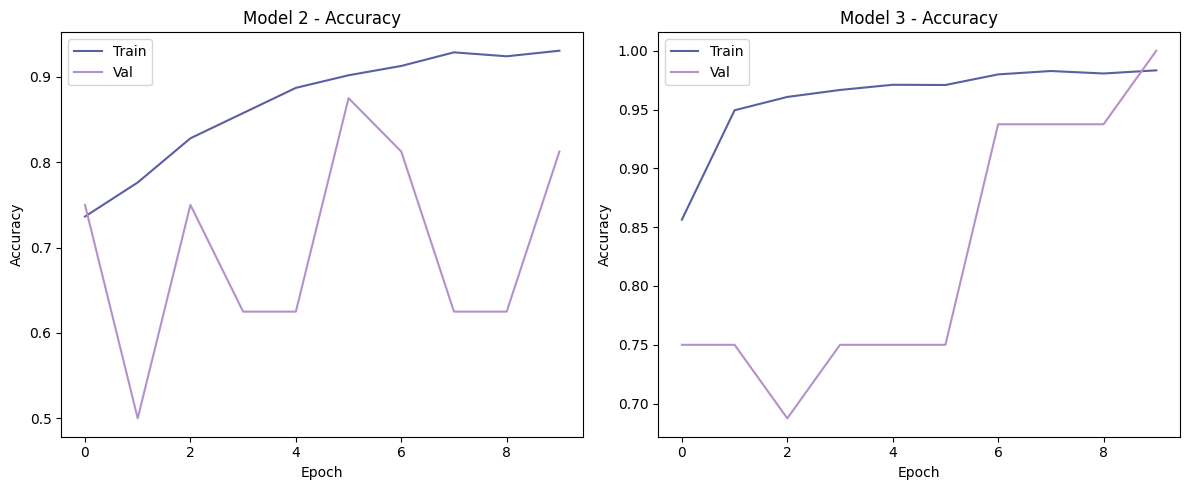

In [56]:
# Plot the training and validation accuracy for Model 2
plt.figure(figsize=(12, 5))

# Plot for Model 2
plt.subplot(1, 2, 1)
plt.plot(results_2.history['accuracy'], color='#5a5ea3')  
plt.plot(results_2.history['val_accuracy'], color='#b491ca')  
plt.title('Model 2 - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot the training and validation accuracy for Model 3
plt.subplot(1, 2, 2)
plt.plot(results_3.history['accuracy'], color='#5a5ea3')  
plt.plot(results_3.history['val_accuracy'], color='#b491ca')  
plt.title('Model 3 - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()


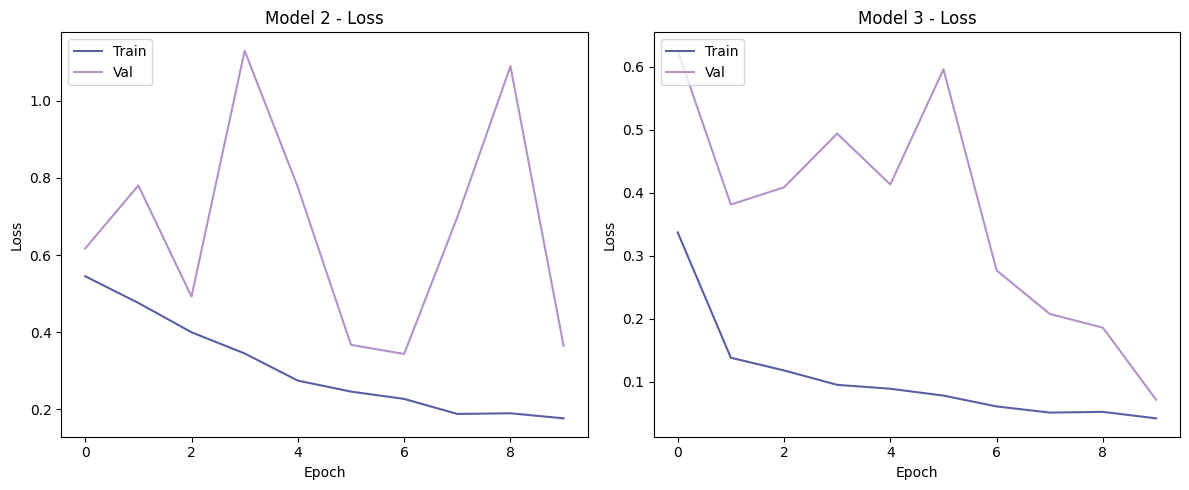

In [57]:
# Plot the training and validation loss for Model 2
plt.figure(figsize=(12, 5))

# Plot for Model 2
plt.subplot(1, 2, 1)
plt.plot(results_2.history['loss'], color='#5a5ea3')  
plt.plot(results_2.history['val_loss'], color='#b491ca')  
plt.title('Model 2 - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot the training and validation loss for Model 3
plt.subplot(1, 2, 2)
plt.plot(results_3.history['loss'], color='#5a5ea3')  
plt.plot(results_3.history['val_loss'], color='#b491ca')  
plt.title('Model 3 - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()


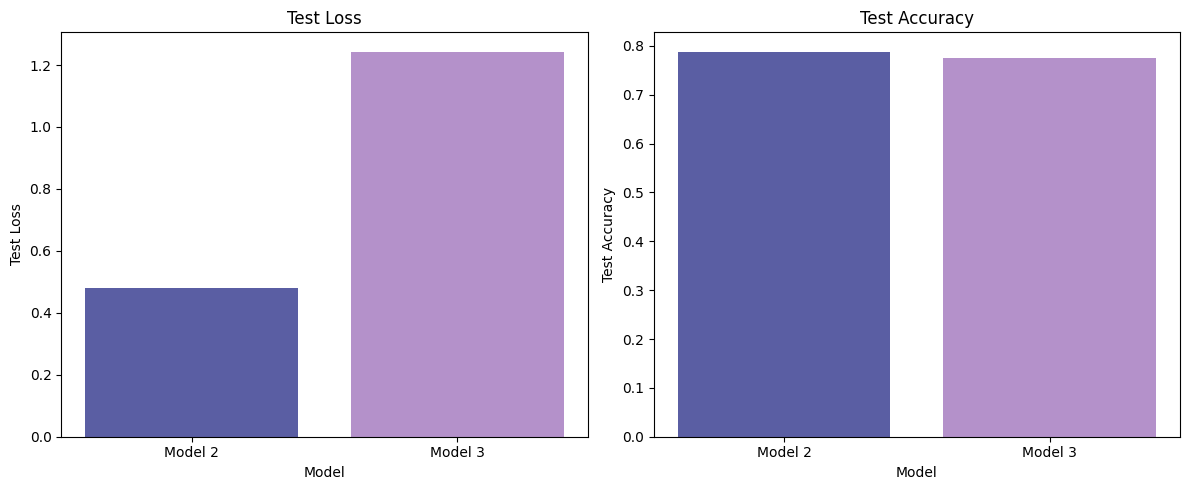

In [58]:
# Comparison of Test Loss and Test Accuracy:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the test loss
ax1.bar(['Model 2', 'Model 3'], [results['Test Loss'][0], results['Test Loss'][1]], color=['#5a5ea3', '#b491ca'])
ax1.set_title('Test Loss')
ax1.set_xlabel('Model')
ax1.set_ylabel('Test Loss')

# Plot the test accuracy
ax2.bar(['Model 2', 'Model 3'], [results['Test Accuracy'][0], results['Test Accuracy'][1]], color=['#5a5ea3', '#b491ca'])
ax2.set_title('Test Accuracy')
ax2.set_xlabel('Model')
ax2.set_ylabel('Test Accuracy')

plt.tight_layout()
plt.show()


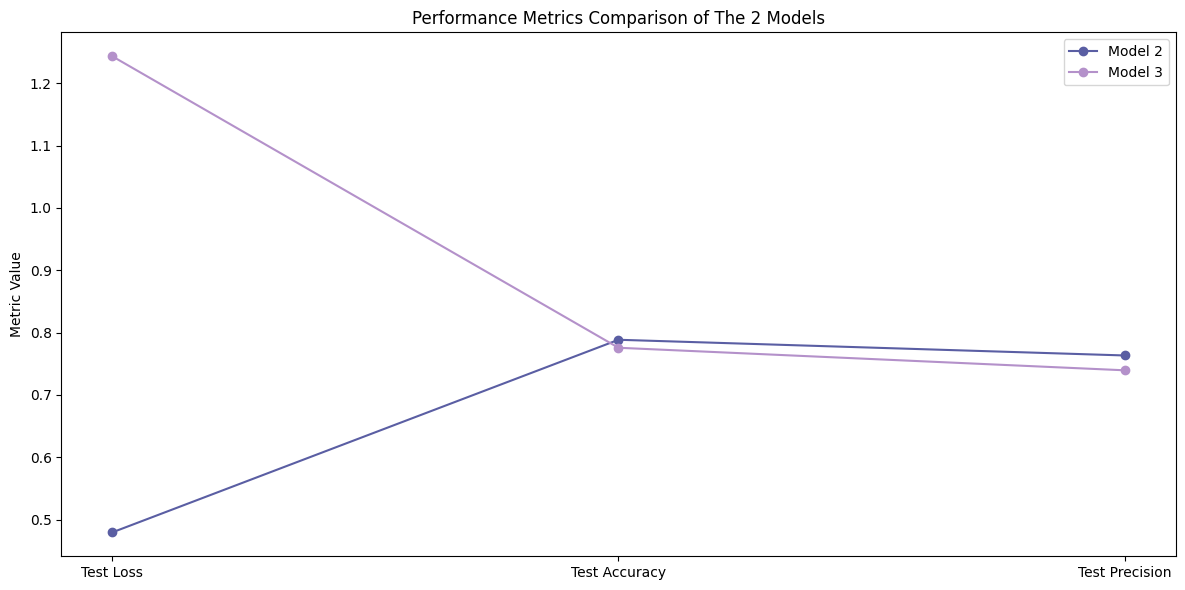

In [60]:
# Visuallization of the Perfomance Metrics of the 2 Models

# Extract the metrics for each model
model2_metrics = [results['Test Loss'][0], results['Test Accuracy'][0], results['Test Precision'][0]]
model3_metrics = [results['Test Loss'][1], results['Test Accuracy'][1], results['Test Precision'][1]]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the metrics for Model 2
ax.plot([1, 2, 3], model2_metrics, label='Model 2', marker='o', color='#5a5ea3')  

# Plot the metrics for Model 3
ax.plot([1, 2, 3], model3_metrics, label='Model 3', marker='o', color='#b491ca')  

# Set the x-axis ticks and labels
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Test Loss', 'Test Accuracy', 'Test Precision'])

# Add labels and title
ax.set_title('Performance Metrics Comparison of The 2 Models')
ax.set_ylabel('Metric Value')
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


Interpretation of Results from the Visualizations and the output.
The performance metrics indicate that the best performing model (Model 3) has the following characteristics:

* Validation Loss: 0.3279 - This low test loss suggests that the model is able to accurately predict the classes of the validation data, with minimal error.
* Test Loss: 1.05 - The increased test loss suggests that the model is requires more training data to be able to accurately predict on unseen data.

* Validation Accuracy: 0.75- The validation accuracy of 75% indicates that the model is able to correctly classify 75% of the validation samples, which is a good performance for a binary classification task.
* Test Accuracy: 0.75 - The Model achieves a similar accuracy for test accuracy of 75% indicates that the model is able to correctly classify 75% of the test samples.

* Test Precision: 0.708- The test precision of 0.7080 means that when the model predicts a sample as "Pneumonia", it is correct 70.80% of the time. This suggests the model has a relatively high precision in identifying positive (pneumonia) cases.


The results show that Model 3 outperforms Model 2 in all three metrics, with a lower test loss, higher test accuracy, and higher test precision.

### Testing Model 3 Predictions


Overall, this processes tests image predictions by the chosed Model_3 based on a threshold and displays the images with their predicted class labels in a visually appealing grid format.

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step


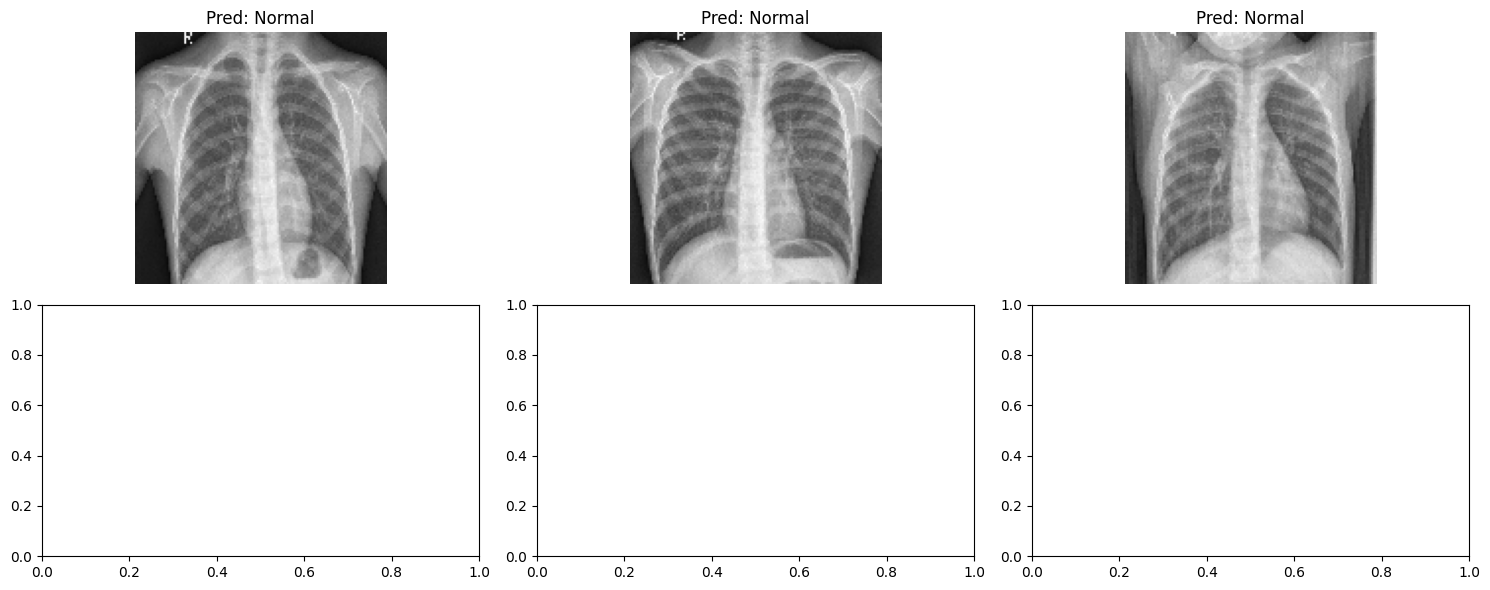

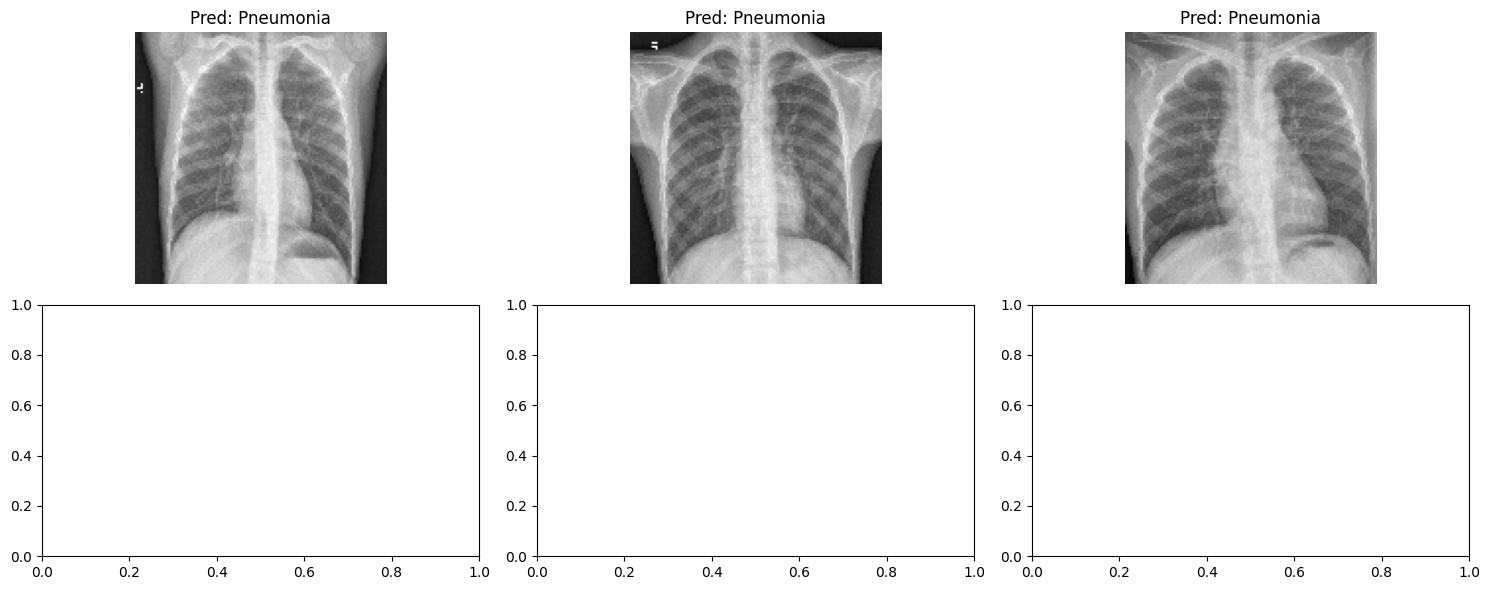

In [37]:

pred = model_3.predict(test_images)
threshold = 0.5

def predict_and_display(image_indices):
    """
    Predicts class labels and displays images based on the given indices.
    """
    fig, axs = plt.subplots(2, 3, figsize=(15, 6))
    for i, index in enumerate(image_indices[:6]):
        image = test_images[index]
        class_label = "Pneumonia" if pred[index] > threshold else "Normal"
        axs[i // 3, i % 3].imshow(image)
        axs[i // 3, i % 3].axis('off')
        axs[i // 3, i % 3].set_title(f"Pred: {class_label}")
    plt.tight_layout()
    plt.show()

def filter_images(indices, threshold_func):
    """
    Filters image indices based on the given threshold function.
    """
    return [index for index in indices if threshold_func(pred[index])]

all_indices = np.arange(len(test_images))
normal_indices = filter_images(all_indices, lambda x: x <= threshold)
pneumonia_indices = filter_images(all_indices, lambda x: x > threshold)

predict_and_display(normal_indices[:3])
predict_and_display(pneumonia_indices[:3])

Overall, the performance metrics demonstrate that Model 4 is able to achieve a good balance between accuracy, precision, and low loss, indicating it is a robust and effective model for the pneumonia classification task.

## 8) Conclusion


The developed deep learning models, particularly Model 3, have shown promising results in accurately detecting pneumonia from chest X-ray images. The models were able to achieve high training accuracy and reasonable validation/test performance, demonstrating their potential for real-world deployment in clinical settings.

The best performing model, "model_3", achieved a test Accuracy of 75% indicates that the model is able to correctly classify 75% of the test samples. This test accuracy although not bad could be improved by using more data such as larger and more diverse dataset of chest X-ray images.

## 9) Recommendation

- Based on the evaluation results, we recommend the deployment of Model 3 as the primary model for pneumonia diagnosis from chest X-rays. This model has exhibited the best overall performance, striking a balance between high accuracy, precision, and low loss. Its integration into hospital workflows and medical imaging analysis systems can significantly enhance the speed and accuracy of pneumonia diagnosis, ultimately leading to improved patient outcomes and more efficient healthcare processes.

- Prospective Clinical Validation: Collaborate with healthcare providers to deploy the model in a real-world clinical setting and conduct a comprehensive evaluation of its performance, practicality, and impact on patient care.

### Next Steps

To further improve the model's performance and ensure its robustness, we suggest the following future work:

* **Expand the Dataset:** Acquire a larger and more diverse dataset of chest X-ray images to improve the model's generalization capabilities and its ability to handle a wider range of pneumonia cases.
* **Pneumonia Severity Classification:**  Instead of just a binary classification (pneumonia vs. normal), extend the model to classify the severity of pneumonia (mild, moderate, severe). This would provide even more actionable insights for doctors.
* **Pneumonia Type Classification:** Differentiate between bacterial and viral pneumonia. This information can guide treatment decisions as antibiotics are ineffective against viruses.
* **Localization of Pneumonia:**  Pinpoint the specific regions of the lung affected by pneumonia in the X-ray image. This can be crucial for further investigation and treatment planning.
* **Cloud-Based Deployment:**  Deploy the model on a cloud platform for remote access and scalability. This would allow for wider adoption and utilization from various hospitals and clinics. 
